## Comparing and Evaluating Clustering Algorithms

One of the challenges in applying clustering algorithms is that it is very hard to assess how well an algorithm worked, and to compare outcomes between different algorithms. After talking about the algorithms behind k-means, agglomerative clustering, and DBSCAN, we will now compare them on some real-world datasets.

### Evaluating Clustering with Ground Truth

There are metrics that can be used to assess the outcome of a clustering algorithm relative to a ground truth clustering, the most important ones being the *adjusted rand index (ARI)* and *normalized mutual information (NMI)*, which both provide a quantitative measure with an optimum of 1 and a value of 0 for unrelated clusterings (though the ARI can become negative).

Here, we compare the k-means, agglomerative clustering, and DBSCAN algorithms using ARI. We also include what it looks like when we randomly assign points to two clusters for comparison:

In [5]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import sklearn
from IPython.display import display
import mglearn

# Don't display deprecation warnings
import warnings
warnings.filterwarnings('ignore')

In [6]:
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

from sklearn.datasets import make_moons

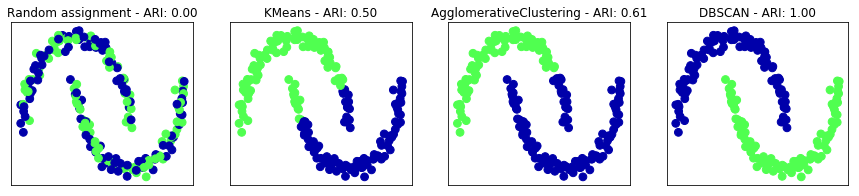

In [7]:
from sklearn.metrics.cluster import adjusted_rand_score
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

# rescale the data to zero mean and unit variance
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

fig, axes = plt.subplots(1, 4, figsize=(15, 3),
                         subplot_kw={'xticks': (), 'yticks': ()})

# make a list of algorithms to use
algorithms = [KMeans(n_clusters=2), AgglomerativeClustering(n_clusters=2),
              DBSCAN()]

# create a random cluster assignment for reference
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X))

# plot random assignment
axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=random_clusters,
                cmap=mglearn.cm3, s=60)
axes[0].set_title("Random assignment - ARI: {:.2f}".format(
        adjusted_rand_score(y, random_clusters)))

for ax, algorithm in zip(axes[1:], algorithms):
    # plot the cluster assignments and cluster centers
    clusters = algorithm.fit_predict(X_scaled)
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters,
               cmap=mglearn.cm3, s=60)
    ax.set_title("{} - ARI: {:.2f}".format(algorithm.__class__.__name__,
                                           adjusted_rand_score(y, clusters)))

The adjusted rand index provides intuitive results, with a random cluster assignment having a score of 0 and DBSCAN (which recovers the desired clustering perfectly) having a score of 1.

A common mistake when evaluating clustering in this way is to use *accuracy_score* instead of *adjusted_rand_score*, *normalized_mutual_info_score*, or some other clustering metric. The problem in using accuracy is that it requires the assigned cluster labels to exactly match the ground truth. However, the cluster labels themselves are meaningless—the only thing that matters is which points are in the same cluster:

In [8]:
from sklearn.metrics import accuracy_score

# These two labelings of points correspond to the same clustering
clusters1 = [0, 0, 1, 1, 0]
clusters2 = [1, 1, 0, 0, 1]

# Accuracy is zero, as none of the labels are the same
print("Accuracy: {:.2f}".format(accuracy_score(clusters1, clusters2)))

# Adjusted rand score is 1, as the clustering is exactly the same
print("ARI: {:.2f}".format(adjusted_rand_score(clusters1, clusters2)))

Accuracy: 0.00
ARI: 1.00


### Evaluating Clustering Without Ground Truth

Although we have just shown one way to evaluate clustering algorithms, in practice, there is a big problem with using measures like ARI. When applying clustering algorithms, there is usually no ground truth to which to compare the results. If we knew the right clustering of the data, we could use this information to build a supervised model like a classifier. Therefore, using metrics like ARI and NMI usually only helps in developing algorithms, not in assessing success in an application.

There are scoring metrics for clustering that don’t require ground truth, like the *silhouette coefficient*. However, these often don’t work well in practice. The silhouette score computes the compactness of a cluster, where higher is better, with a perfect score of 1. While compact clusters are good, compactness doesn’t allow for complex shapes.

Here is an example comparing the outcome of k-means, agglomerative clustering, and DBSCAN on the two-moons dataset using the silhouette score:

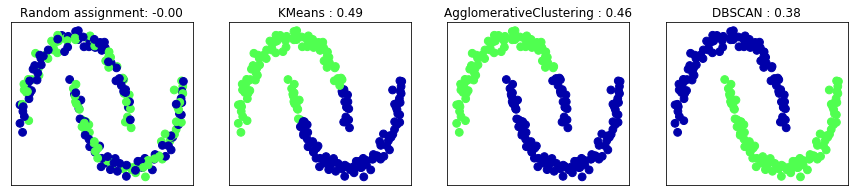

In [9]:
from sklearn.metrics.cluster import silhouette_score

X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

# Rescale the data to zero mean and unit variance
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

fig, axes = plt.subplots(1, 4, figsize=(15, 3),
                         subplot_kw={'xticks': (), 'yticks': ()})

# Create a random cluster assignment for reference
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X))

# Plot random assignment
axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=random_clusters,
                cmap=mglearn.cm3, s=60)
axes[0].set_title("Random assignment: {:.2f}".format(
    silhouette_score(X_scaled, random_clusters)))

algorithms = [KMeans(n_clusters=2), AgglomerativeClustering(n_clusters=2),
              DBSCAN()]

for ax, algorithm in zip(axes[1:], algorithms):
    clusters = algorithm.fit_predict(X_scaled)
    # plot the cluster assignments and cluster centers
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap=mglearn.cm3,
               s=60)
    ax.set_title("{} : {:.2f}".format(algorithm.__class__.__name__,
                                      silhouette_score(X_scaled, clusters)))

As you can see, k-means gets the highest silhouette score, even though we might prefer the result produced by DBSCAN. A slightly better strategy for evaluating clusters is using robustness-based clustering metrics. These run an algorithm after adding some noise to the data, or using different parameter settings, and compare the outcomes. The idea is that if many algorithm parameters and many perturbations of the data return the same result, it is likely to be trustworthy. 

Unfortunately, this strategy is not implemented in scikit-learn at the time of writing.

Even if we get a very robust clustering, or a very high silhouette score, we still don’t know if there is any semantic meaning in the clustering, or whether the clustering reflects an aspect of the data that we are interested in. 

Let’s go back to the example of face images. We hope to find groups of similar faces—say, men and women, or old people and young people, or people with beards and without. Let’s say we cluster the data into two clusters, and all algorithms agree about which points should be clustered together. We still don’t know if the clusters that are found correspond in any way to the concepts we are interested in. It could be that they found side views versus front views, or pictures taken at night versus pictures taken during the day, or pictures taken with iPhones versus pictures taken with Android phones. The only way to know whether the clustering corresponds to anything we are interested in is to analyze the clusters manually.